In [45]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from scipy.stats import boxcox
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore") # отключает предупреждения

In [2]:
file = 'source.xlsx'
x1 = pd.ExcelFile(file)
x1.sheet_names
df = x1.parse('days')
gb = df[['report_dt', 'val']].resample('D', on='report_dt').sum() \
        .query('val > 0')

In [3]:
full_data = gb['2019-06':'2020-11']
dataset = gb['2019-06':'2020-10']
validation = gb['2020-11']
print(f'Full Data {len(full_data)}, Dataset {len(dataset)}, Validation {len(validation)}')

Full Data 463, Dataset 445, Validation 18


In [68]:
# проверка на стационарность
def check_stationary(dataset):
    check = sm.tsa.adfuller(dataset)
    print(f'adf: {check[0]}')
    print(f'p-value: {check[1]}')
    print(f'Critical values: {check[4]}')
    if check[0]> check[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')
        
# создаем дифференцированный ряд
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# добавим ценность наблюдения год назад
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [81]:
# Сделаем наивный прогноз на тестовой выборке

X = dataset.squeeze()
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# проверка с шагом вперед
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # предсказание
    yhat = history[-1]
    predictions.append(yhat)
    # текущее наблюдение
    obs = test[i]
    history.append(obs)
    print('>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    
# отчёт
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)

print('RMSE: %.3f' % rmse)

predictions_series = pd.Series(data=predictions, index=test.index)

>Predicted = 103.467, Expected = 117
>Predicted = 116.503, Expected = 214
>Predicted = 214.451, Expected = 104
>Predicted = 103.852, Expected =  99
>Predicted = 99.352, Expected =  97
>Predicted = 96.933, Expected = 101
>Predicted = 100.644, Expected = 109
>Predicted = 109.323, Expected = 184
>Predicted = 184.118, Expected =  86
>Predicted = 85.947, Expected = 102
>Predicted = 101.897, Expected = 104
>Predicted = 104.252, Expected =  96
>Predicted = 95.910, Expected =  93
>Predicted = 93.482, Expected = 291
>Predicted = 290.522, Expected =  73
>Predicted = 73.022, Expected = 120
>Predicted = 119.532, Expected =  90
>Predicted = 89.673, Expected =  95
>Predicted = 94.976, Expected = 101
>Predicted = 100.746, Expected = 166
>Predicted = 166.401, Expected =  78
>Predicted = 78.385, Expected =  99
>Predicted = 98.523, Expected = 107
>Predicted = 106.568, Expected = 101
>Predicted = 100.892, Expected = 112
>Predicted = 111.775, Expected = 208
>Predicted = 208.068, Expected = 119
>Predicted 

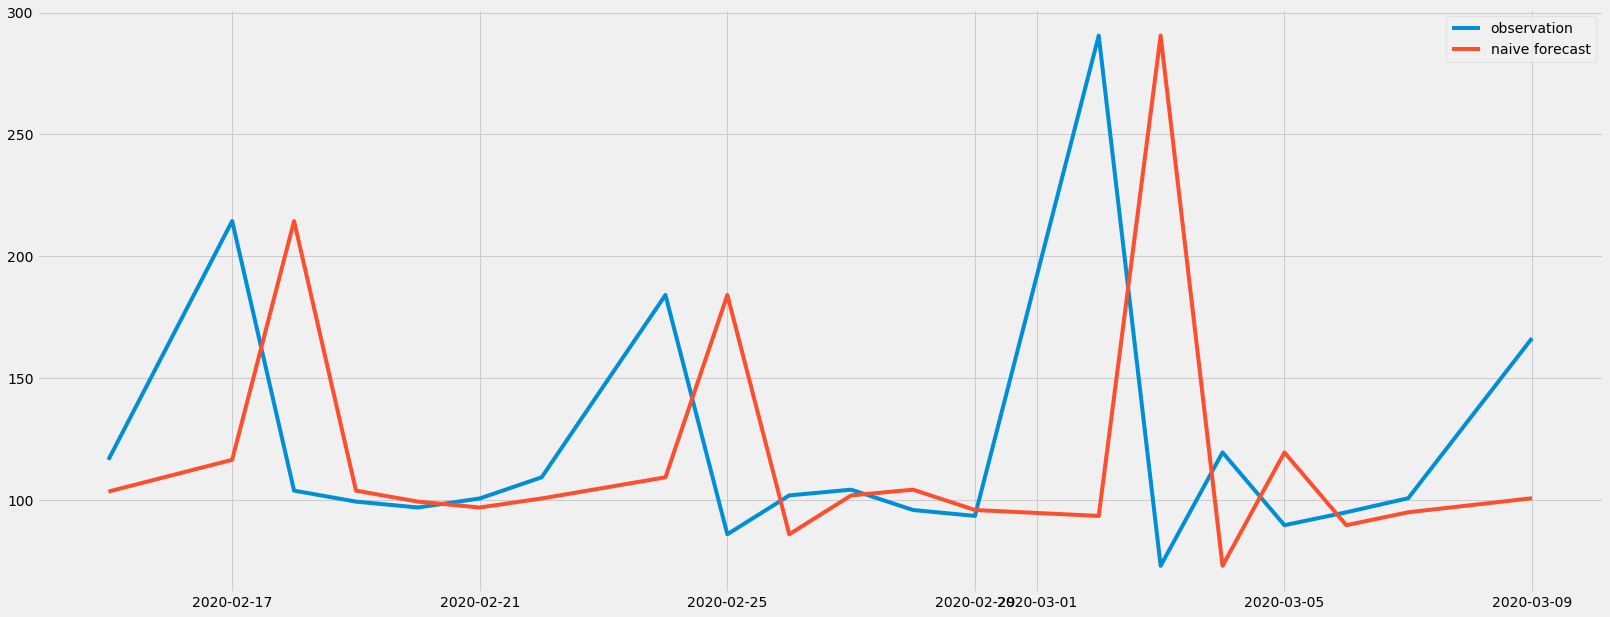

In [70]:
# построим графики для первых 20 наблюдений
plt.figure(figsize=(25, 10))
plt.plot(test.head(20), label='observation')
plt.plot(predictions_series.head(20), label='naive forecast')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

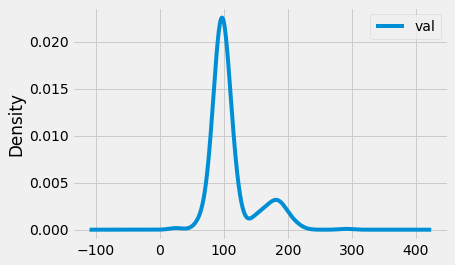

In [71]:
# График плотности наблюдений 
plt.figure()
dataset.plot(kind='kde')
plt.show()

! Распределение не является гауссовым

Анализ данных временного ряда предполагает, что мы работаем со стационарным временным рядом.
Если временной ряд не является стационарным, мы можем сделать его стационарным, сначала дифференцируя ряд и используя статистический тест Дики-Фуллера, чтобы удостовериться в нашем предположении.

In [72]:
# Проверим ряд datset на стационарность
check_stationary(dataset)

adf: -5.222260773448972
p-value: 7.917174454878717e-06
Critical values: {'1%': -3.445757604526768, '5%': -2.8683325885102855, '10%': -2.5703882165206853}
единичных корней нет, ряд стационарен


Результаты теста показывают, что статистическое значение теста -5.22 меньше критического значения в 5% от -2.868. Это говорит о том, что мы можем отклонить нулевую гипотезу с уровнем значимости менее 5% (т.е. низкая вероятность того, что в результате получится статистическая случайность).

Отказ от нулевой гипотезы означает, что процесс не имеет единичного корня и, в свою очередь, временной ряд является стационарным или не имеет временной структуры.

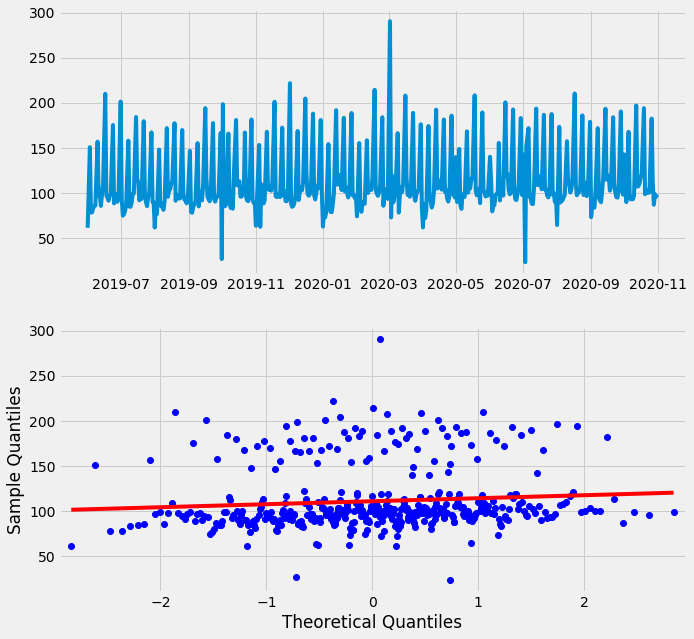

In [82]:
plt.figure(figsize=(10,10))
# line plot
plt.subplot(211)
plt.plot(dataset)
# q-q plot
plt.subplot(212)
qqplot(dataset, line='r', ax=plt.gca())
plt.show()

Данные не ложатся на линию тренда

Преобразование Бокса-Кокса - это метод, который способен оценивать набор степенных преобразований

Lambda: -0.187335


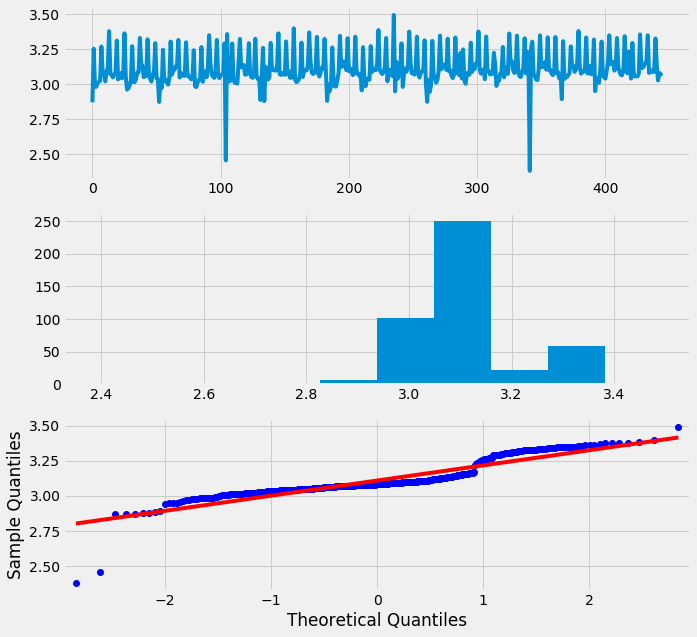

In [74]:
X = dataset.squeeze()
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)

plt.figure(figsize=(10,10))
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

График q-q (нижний) показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок

Сгруппируем данные по месяцам

In [37]:
gb_month = df[['report_dt', 'val']].resample('M', on='report_dt').sum() \
        .query('val > 0')

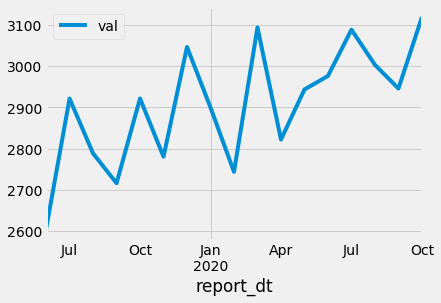

In [38]:
gb_month['2019-06':'2020-10'].plot()

In [75]:
check_stationary(gb_month['2019-06':'2020-10'])

adf: -0.8164282954758675
p-value: 0.8142486863619294
Critical values: {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}
есть единичные корни, ряд не стационарен


Тест Дики-Фуллера для временного ряда по месяцам показывает, что ряд не стационарен

>Predicted = 149.765, Expected = 151
>Predicted = 89.252, Expected =  86
>Predicted = 89.229, Expected =  87
>Predicted = 84.546, Expected =  91
>Predicted = 92.530, Expected =  95
>Predicted = 96.462, Expected =  99
>Predicted = 170.004, Expected = 164
>Predicted = 92.912, Expected =  94
>Predicted = 107.869, Expected = 107
>Predicted = 112.879, Expected = 111
>Predicted = 101.050, Expected = 102
>Predicted = 115.280, Expected = 120
>Predicted = 209.961, Expected = 205
>Predicted = 119.763, Expected = 128
>Predicted = 103.852, Expected = 107
>Predicted = 99.483, Expected = 105
>Predicted = 111.562, Expected = 103
>Predicted = 109.351, Expected = 113
RMSE: 4.404


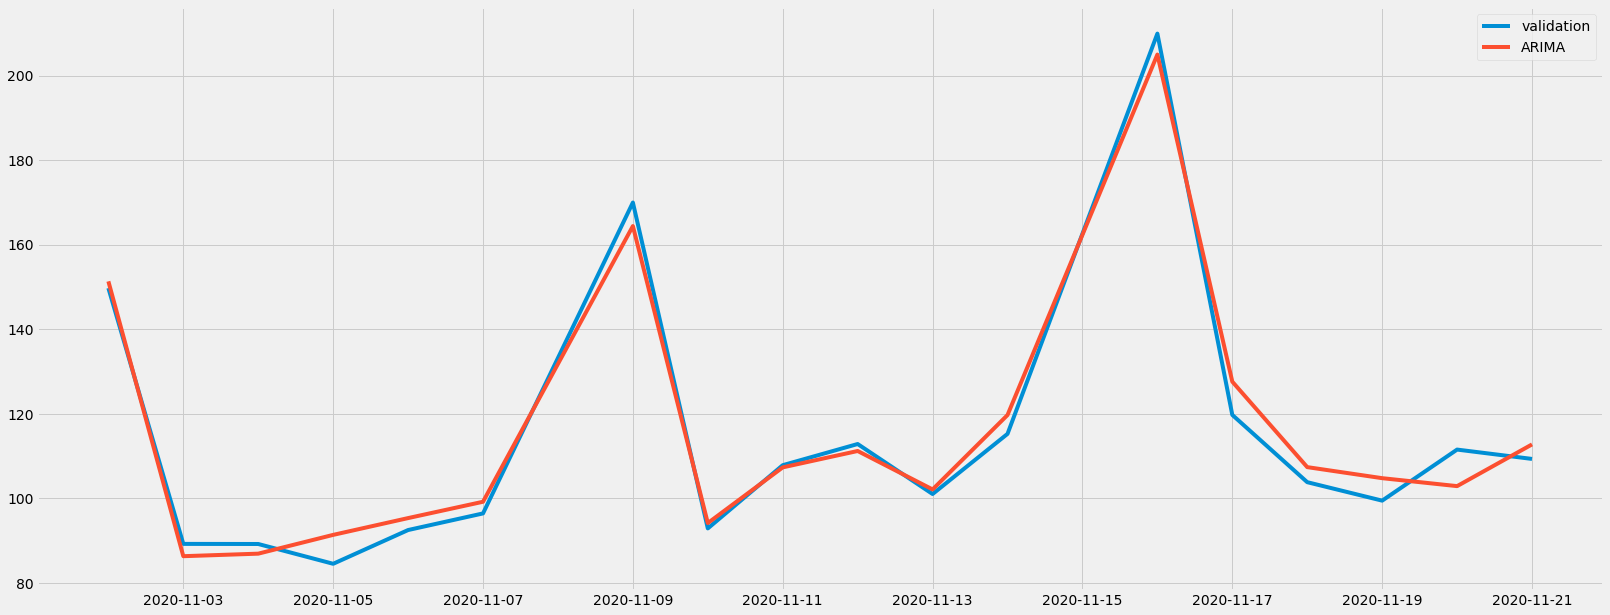

In [77]:
# построим модель ARIMA. Манипулируем данными, сгруппированными по ДНЯМ! 

X = dataset.squeeze()
days_in_year = 366

# сезонная разность
differenced = difference(X, days_in_year)

# построение модели
model = ARIMA(differenced, order=(4,2,0))
model_fit = model.fit(disp=0)

# вывести информацию о модели
# print(model_fit.summary())

#количество шагов для прогнозирования
steps = len(validation) 

forecast = model_fit.forecast(steps=steps)[0]

# инвертировуем сезонную разность; обратное преобразование значения в исходную шкалу
history = [x for x in X]
count = 0
res = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('>Predicted = %.3f, Expected = %3.f' % (validation.squeeze()[count], inverted))
    history.append(inverted)
    res.append(inverted)
    count += 1
    
forecast_series = pd.Series(data=res, index=validation.index)

# подсчёт среднеквад. ошибки
mse = mean_squared_error(validation.squeeze(), res)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# строим графики
plt.figure(figsize=(25,10))
plt.plot(validation, label='validation')
plt.plot(forecast_series, label='ARIMA')
plt.legend()
plt.show()

In [78]:
# индексы для предсказанных значений
predict_index = pd.Series(pd.date_range(start='22/11/2020', end='30/11/2020'))

# итератор по дням
iter_day = iter(list(predict_index.dt.day.values))

X = full_data.squeeze()
days_in_year = 366
differenced = difference(X, days_in_year)

# построение модели
model = ARIMA(differenced, order=(4,2,0))
model_fit = model.fit(disp=0)

# многошаговый прогноз
start_index = len(differenced)
end_index = start_index + len(predict_index)
forecast = model_fit.predict(start=start_index, end=end_index)

# инвертировуем сезонную разность; обратное преобразование значения в исходную шкалу
history = [x for x in X]
res = []
for yhat in forecast:
    try:
        inverted = inverse_difference(history, yhat, days_in_year)
        print(f'{next(iter_day)}-11-2020: {inverted}')
        history.append(inverted)
        res.append(inverted)
    except StopIteration:
        print('Итератор отработал')
        continue

predict_series = pd.Series(data=res, index=predict_index)

22-11-2020: 192.71179398532746
23-11-2020: 95.99250737679304
24-11-2020: 84.51237132241597
25-11-2020: 95.27136026452979
26-11-2020: 98.94242653347031
27-11-2020: 97.80886036314826
28-11-2020: 164.12615715559798
29-11-2020: 27.656579231478243
30-11-2020: 199.63062334545472
Итератор отработал


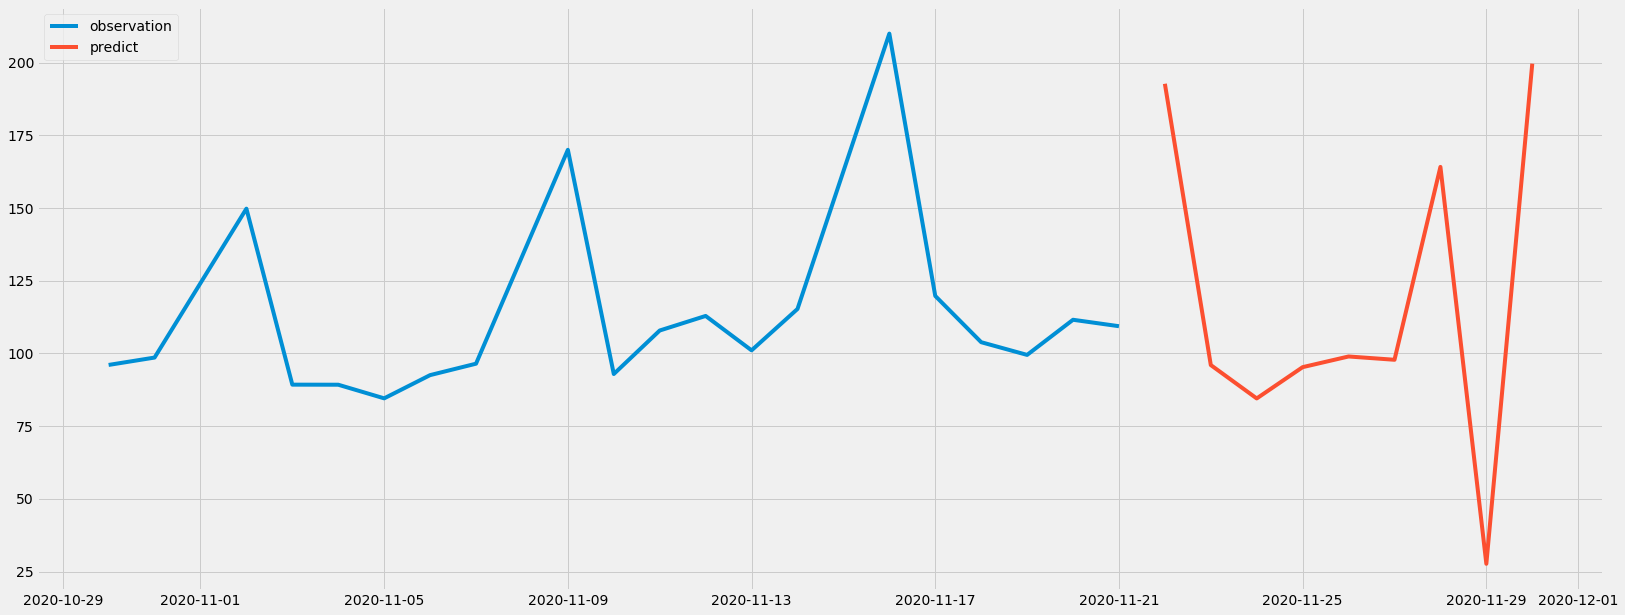

In [79]:
plt.figure(figsize=(25,10))
plt.plot(full_data.tail(20), label='observation')
plt.plot(predict_series.head(20), label='predict')
plt.legend(loc='upper left')
plt.show()

In [80]:
november_predict = round(validation['val'].sum() + predict_series.sum(), 3)
print(f'Проноз на ноябрь 2020 года: {november_predict}')

Проноз на ноябрь 2020 года: 3112.403
